In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as smg
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pymc.sampling_jax
import numpyro
import blackjax
import jax
from sklearn.preprocessing import StandardScaler
import arviz as az


settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5,
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)

SEED = sum(map(ord, 'Forcasting in PyMC'))
rng = np.random.default_rng(SEED)

### Plot helpers

In [2]:
def plot_results(idata, test_data=None, oos_name='Test'):
    groups = ['posterior_predictive', 'predictions', 'observed_data']
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    labels = ['Training', oos_name, 'Data']
    fig, ax = plt.subplots()
    
    time_dim_name = list(idata.observed_data.dims.keys())[0]
    x_train = idata.observed_data.coords[time_dim_name]
    
    H = list(idata.predictions.dims.values())[-1]
    x_test = np.arange(x_train[-1], x_train[-1] + H)
    
    x_values = [x_train, x_test, x_train]
    
    for group, color, label, x_val in zip(groups, colors, labels, x_values):
        data = getattr(idata, group).y_hat
        
        if group == 'observed_data':
            ax.plot(x_val, data, c=color, label=label)
            continue
            
        hdi = az.hdi(data).y_hat
        ax.plot(x_val, data.mean(dim=['chain', 'draw']), label=label)
        ax.fill_between(x_val, *hdi.values.T, color=color, alpha=0.25)
    if test_data is not None:
        ax.plot(x_test, test_data, color='tab:red')
    ax.legend()
    plt.show()

In [ ]:
data = pd.read_csv(r'../data/startups.csv', index_col=[0], date_format="mm/dd/yyyy")
print(data.columns)
data.rename(columns = {'All Economic Activities, Total Business Start-Ups': 'Startups'}, inplace = True)
data.plot()

### Raw data shows autocorrelation/nonstationarity

In [ ]:
y = data['Startups'].values

_, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(y)
smg.plot_acf(y, lags=20, ax=ax2);
smg.plot_pacf(y, lags=20, ax=ax3);

### Standardize

In [ ]:
data['Startups_stdz'] = data['Startups'].transform(lambda x: (x - x.mean()) / x.std())

y = data['Startups_stdz'].values

_, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(y)
smg.plot_acf(y, lags=20, ax=ax2);
smg.plot_pacf(y, lags=20, ax=ax3);

### Non-Recursive Deterministic Trend

$
y_t = \alpha + \gamma t + \epsilon_t 
$

In [6]:
T = y.shape[0]
t = np.arange(T)

In [ ]:
train_data = y[:66]
test_data = y[-4:]

plt.plot(train_data, color='tab:blue')
plt.plot(np.arange(66, 70), test_data, ls='--', color='tab:red')

In [ ]:
with pm.Model() as det_trend:
    t_pt = pm.MutableData('t', t[:66])
    alpha = pm.Normal('alpha')
    gamma = pm.Normal('gamma')
    
    mu = pm.Deterministic('mu', alpha + gamma * t_pt)
    sigma = pm.Exponential('sigma', 1)
    
    y_hat = pm.StudentT('y_hat', mu=mu, nu=5, sigma=sigma, observed=train_data.flatten(), shape=t_pt.shape)
    idata = pm.sample()

In [ ]:
with det_trend:
    #in-sample 
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    
    #out-of-sample
    pm.set_data({'t':t[-4:]})
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

In [ ]:
plot_results(idata, test_data)

### Prophet type model

In [11]:


def create_piecewise_trend(t, t_max, n_changepoints):    
    s = pt.linspace(0, t_max, n_changepoints+2)[1:-1]
    A = (t[:, None] > s)*1
    return A, s

def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)

def generate_features(t, t_max, n_changepoints=10, n_fourier=6, p=365.25):
    A, s = create_piecewise_trend(t, t_max, n_changepoints)
    X = create_fourier_features(t, n_fourier, p)
    
    return A, s, X

In [20]:
t_max = T #from above

with pm.Model() as prophet_model:

    # data: Xs
    t_pt = pm.Data('t', t)
    A, s, X = generate_features(t_pt, t_max, n_changepoints=4, n_fourier=4, p=4)
    
    # priors
    initial_slope = pm.Normal('initial_slope') # standard normal
    initial_intercept = pm.Normal('initial_intercept') # standard normal
    
    # n_changepoint offsets terms to build the piecewise trend
    deltas = pm.Normal('offset_delta', shape=(4,))
        
    intercept = initial_intercept + ((-s * A) * deltas).sum(axis=1)
    slope = initial_slope + (A * deltas).sum(axis=1)
    
    # n_fourier * 2 seasonal coefficients
    beta = pm.Normal('beta', size=8)
    
    mu = pm.Deterministic('mu', intercept + slope * t_pt + X @ beta)
    sigma = pm.Exponential('sigma', 1)
    y_hat = pm.StudentT('y_hat', mu=mu, nu = 3, sigma=sigma, observed=y.ravel(), shape=t_pt.shape)
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [initial_slope, initial_intercept, offset_delta, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


In [21]:
with prophet_model:
    #in-sample 
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    
    #out-of-sample
    last_t = t[-1]
    
    # Forcast 3 years of home sales
    forcast_t = np.arange(last_t, last_t + 4)
    pm.set_data({'t':forcast_t})
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

Sampling: [y_hat]


Output()

Sampling: [y_hat]


Output()

C:\Users\jpark\AppData\Local\Temp\ipykernel_21608\2490698906.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_dim_name = list(idata.observed_data.dims.keys())[0]
C:\Users\jpark\AppData\Local\Temp\ipykernel_21608\2490698906.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  H = list(idata.predictions.dims.values())[-1]
<frozen _collections_abc>:913: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Datas

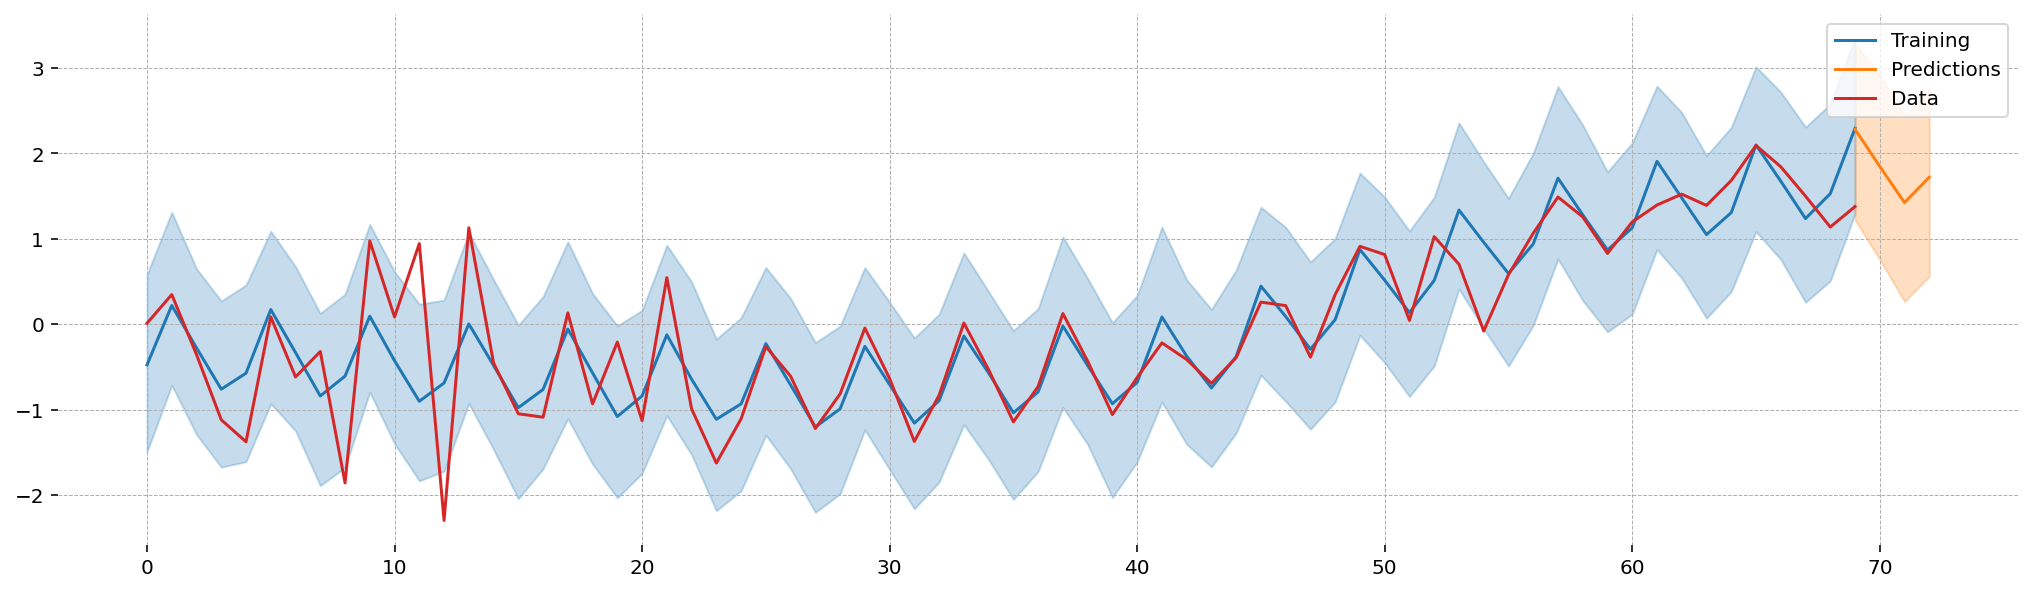

In [22]:
plot_results(idata, oos_name='Predictions')